In [ ]:
from Agents import FCFFwdUnsupAgent
from SupModules import FCFFwdSupModule
from MetaOptimizationMethods import GeneticMethodB
import torch
from SemiSupMethods import SemiSupMethod1
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from time import time as tm
import warnings
import matplotlib.cm as colormap
import seaborn as sns
import matplotlib.colors

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")


# Number of unsupervised and supervised
# iterations for semi-sup  learning
NumItUnsup = 10
NumItSup = 50

# Batch sizes
unsup_batch_size = 64
train_batch_size = 64
test_batch_size = 64

# Number of generations
NumGenerations = 10

# Population size
PopSize = 50

# Standard deviation for initializing
# meta-params
InitialMetaParamStd = .002

# Evolutionary hyperparams
Temperature = .001
NumParents = (int)(PopSize / 4)
lam = 0

# Hyperparams for unsup agents
UnsupHyperParams = {}
UnsupHyperParams["Depth"] = 4
UnsupHyperParams["InWidth"] = 32*32*3
UnsupHyperParams["HiddenWidth"] = 128
UnsupHyperParams["OutWidth"] = 128
UnsupHyperParams["gHidden"] = torch.tanh
UnsupHyperParams["gLast"] = torch.tanh  # nn.ReLU()

# Hyperparams for sup module
SupHyperParams = {}
SupHyperParams["Depth"] = 4
SupHyperParams["InWidth"] = UnsupHyperParams["OutWidth"]
SupHyperParams["HiddenWidth"] = 128
SupHyperParams["OutWidth"] = 10
SupHyperParams["gHidden"] = nn.ReLU()
SupHyperParams["gLast"] = nn.Identity()


# Function to get an initialized supervised learning module
def SupModuleGetter():
    return FCFFwdSupModule(SupHyperParams)


# # Import and build data loaders
# from torchvision.datasets import MNIST

# train_dataset = MNIST('./',
#                       train=True,
#                       transform=transforms.ToTensor(),
#                       download=True)
# test_dataset = MNIST('./',
#                      train=False,
#                      transform=transforms.ToTensor(),
#                      download=True)
# unsup_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=unsup_batch_size,
#                                            shuffle=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=train_batch_size,
#                                            shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=test_batch_size,
#                                           shuffle=True)

# # Import and build data loaders
# from torchvision.datasets import CIFAR10
# train_dataset = CIFAR10('./',
#       train=True,
#       transform=transforms.ToTensor(),
#       download=True)
# test_dataset = CIFAR10('./',
#       train=False,
#       transform=transforms.ToTensor(),
#       download=True)
# unsup_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=unsup_batch_size,
#                                           shuffle=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=train_batch_size,
#                                           shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=test_batch_size,
#                                           shuffle=True)


from torchvision.datasets import STL10
unsup_loader = STL10('./',
      split='unlabeled',
      transform=transforms.ToTensor(),
      download=True)

train_loader = STL10('./',
      split='train',
      transform=transforms.ToTensor(),
      download=True)

test_loader = STL10('./',
      split='test',
      transform=transforms.ToTensor(),
      download=True)


# iInitialize meta-parameters
NumMetaParams = 8
MetaParams = torch.zeros(NumGenerations, PopSize, NumMetaParams)
MetaParams[0, :, :] = InitialMetaParamStd * torch.randn(PopSize, NumMetaParams)

# Supervised loss function and optimizer
SupLossFun = nn.CrossEntropyLoss()
SupOptimizerGetter = torch.optim.Adam

# Semi-supervised learning method
method1 = SemiSupMethod1(SupModuleGetter, SupLossFun, SupOptimizerGetter, NumItUnsup, NumItSup)

# Create a population of unsupervised learning agents
Population = [FCFFwdUnsupAgent(MetaParams[0, j, :], UnsupHyperParams, device) for j in range(PopSize)]

#method1.UnsupLifetime(Population, unsup_loader)

# Ignore warning messages
# Initialize other stuff
t0 = tm()
MetaLoss = torch.zeros(NumGenerations, PopSize)
MeanLossCurves = torch.zeros(NumGenerations, NumItSup)
MeanAccuracyCurves = torch.zeros(NumGenerations, NumItSup)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # For each generation
    for i in range(NumGenerations):
        # Store meta-params for this generation
        MetaParams[i, :, :] = torch.stack([p.MetaParams for p in Population])

        # Perform unsupervised learning on population
        method1.UnsupLifetime(Population, unsup_loader)

        # Perform supervised learning from population to comptue meta-loss
        MetaLoss[i, :] = method1.ComputeMetaLoss(Population, train_loader, test_loader)

        # Store population-averaged training loss and accuracy curves
        MeanLossCurves[i, :] = method1.TrainLossCurve
        MeanAccuracyCurves[i, :] = method1.TrainAccuracyCurve

        GeneticMethodB(Population, MetaLoss[i, :], Temperature, NumParents, MinWeight=.5, lam=0)

        t1 = tm()
        print('Generation', i, 'of', NumGenerations, 'Metaloss:', MetaLoss[i, :].mean().item(), 'runtime:', t1 - t0, 's')


print('done')

Using device: mps


 22%|██▏       | 568819712/2640397119 [09:49<1:17:35, 444986.29it/s]

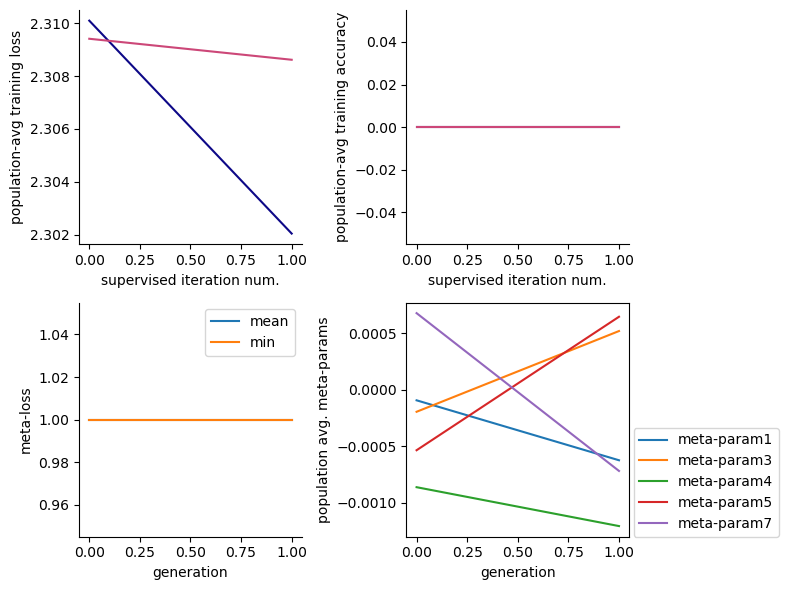

In [2]:

# choose a colormap
cm=colormap.plasma
plt.figure(figsize=(8,6))

# Plot training loss curves at all generations
# averaged over population
plt.subplot(2,2,1)
for i in range(NumGenerations):
  plt.plot(MeanLossCurves[i,:].numpy(),color=cm(i/NumGenerations),label=i)
#plt.legend(loc=[1,0])
#plt.colorbar(colormap.ScalarMappable(cmap=cm),label='generation/NumGenerations')
plt.xlabel('supervised iteration num.')
plt.ylabel('population-avg training loss')
sns.despine()

# Plot training accuracy curves at all generations
# averaged over population
plt.subplot(2,2,2)
for i in range(NumGenerations):
  plt.plot(MeanAccuracyCurves[i,:].numpy(),color=cm(i/NumGenerations),label=i)
#plt.colorbar(colormap.ScalarMappable(cmap=cm),label='generation/NumGenerations')
plt.xlabel('supervised iteration num.')
plt.ylabel('population-avg training accuracy')
sns.despine()

# Plot mean and min meta-losses across generations
plt.subplot(2,2,3)
plt.plot(MetaLoss.numpy().mean(axis=1),label='mean')
plt.plot(MetaLoss.numpy().min(axis=1),label='min')
plt.xlabel('generation')
plt.ylabel('meta-loss')
plt.legend()
sns.despine()

# Plot Mean and Best meta-params across generations
plt.subplot(2,2,4)
for jj in [1,3,4,5,7]:#range(NumMetaParams):
  plt.plot(MetaParams[:,:,jj].numpy().mean(axis=1),label='meta-param'+str(jj))
plt.legend(loc=(1.02,0))
plt.xlabel('generation')
plt.ylabel('population avg. meta-params')


plt.tight_layout()



In [2]:
from Agents import FCFFwdUnsupAgent
from SupModules import FCFFwdSupModule
from MetaOptimizationMethods import GeneticMethodB
import torch
from SemiSupMethods import SemiSupMethod1
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from time import time as tm
import warnings
import matplotlib.cm as colormap
import seaborn as sns
import matplotlib.colors

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")


# Number of unsupervised and supervised
# iterations for semi-sup  learning
NumItUnsup = 2#10
NumItSup = 2#50

# Batch sizes
unsup_batch_size = 16#64
train_batch_size = 16#64
test_batch_size = 16#64

# Number of generations
NumGenerations = 2#10

# Population size
PopSize = 10#100

# Standard deviation for initializing
# meta-params
InitialMetaParamStd = .002

# Evolutionary hyperparams
Temperature = .001
NumParents = (int)(PopSize / 4)
lam = 0

# Hyperparams for unsup agents
UnsupHyperParams = {}
UnsupHyperParams["Depth"] = 3
UnsupHyperParams["InWidth"] = 28 * 28  # 32*32*3
UnsupHyperParams["HiddenWidth"] = 16#64
UnsupHyperParams["OutWidth"] = 16#64
UnsupHyperParams["gHidden"] = torch.tanh
UnsupHyperParams["gLast"] = torch.tanh  # nn.ReLU()

# Hyperparams for sup module
SupHyperParams = {}
SupHyperParams["Depth"] = 3
SupHyperParams["InWidth"] = UnsupHyperParams["OutWidth"]
SupHyperParams["HiddenWidth"] = 16#64
SupHyperParams["OutWidth"] = 10
SupHyperParams["gHidden"] = nn.ReLU()
SupHyperParams["gLast"] = nn.Identity()


# Function to get an initialized supervised learning module
def SupModuleGetter():
    return FCFFwdSupModule(SupHyperParams)


# Import and build data loaders
from torchvision.datasets import MNIST

train_dataset = MNIST('./',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)
test_dataset = MNIST('./',
                     train=False,
                     transform=transforms.ToTensor(),
                     download=True)
unsup_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=unsup_batch_size,
                                           shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                           shuffle=True)


# iInitialize meta-parameters
NumMetaParams = 8
MetaParams = torch.zeros(NumGenerations, PopSize, NumMetaParams)
MetaParams[0, :, :] = InitialMetaParamStd * torch.randn(PopSize, NumMetaParams)

# Supervised loss function and optimizer
SupLossFun = nn.CrossEntropyLoss()
SupOptimizerGetter = torch.optim.Adam

# Semi-supervised learning method
method1 = SemiSupMethod1(SupModuleGetter, SupLossFun, SupOptimizerGetter, NumItUnsup, NumItSup)

# Create a population of unsupervised learning agents
Population = [FCFFwdUnsupAgent(MetaParams[0, j, :], UnsupHyperParams, device) for j in range(PopSize)]


Using device: mps
mps
mps:0
mps:0
mps:0
mps:0
mps:0


In [14]:
temp=torch.randn(5).to('cpu')

device(type='mps', index=0)